In [22]:
%reset -sf

import tensorflow as tf
import tf_keras
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)

# Enable XLA if desired
tf.config.optimizer.set_jit(True)
print("XLA enabled:", tf.config.optimizer.get_jit())
    
# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Enable memory growth for the first GPU
        # memory_limit = 16_376 / 2 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Tensorflow: 2.16.1
Tensorflow Probability: 0.24.0
XLA enabled: autoclustering
1 Physical GPUs, 1 Logical GPU


In [23]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap

plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [24]:
tf.__version__

'2.16.1'

In [25]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
truth_dilep = data.Truth_dilep()
truth_lead_nu = data.Truth_lead_nu()
truth_sublead_nu = data.Truth_sublead_nu()
truth_met = data.Truth_met()
# additional variable to check the neutrinos
truth_lead_nu = data.Truth_lead_nu()
print(truth_lead_nu.__dir__())
truth_sublead_nu = data.Truth_sublead_nu()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
higgs_4vect = w_lead.p4 + w_sublead.p4

['__module__', 'px', 'py', 'pz', 'energy', 'pt', 'eta', 'phi', 'p4', 'p3', '__dict__', '__weakref__', '__doc__', '__dataclass_params__', '__dataclass_fields__', '__init__', '__repr__', '__eq__', '__hash__', '__match_args__', '__new__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__ne__', '__gt__', '__ge__', '__reduce_ex__', '__reduce__', '__getstate__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [26]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > -9999
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [27]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()

In [28]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        # lead_lep.pz,
        # lead_lep.energy,
        np.log(lead_lep.energy),
        # np.log(lead_lep.pt),
        lead_lep.eta,
        # lead_lep.phi,
        sublead_lep.px,
        sublead_lep.py,
        # sublead_lep.pz,
        # sublead_lep.energy,
        np.log(sublead_lep.energy),
        # np.log(sublead_lep.pt),
        sublead_lep.eta,
        # sublead_lep.phi,
        met.px,
        met.py,
        # met.pt,
        # met.phi,
        # dilep.px,
        # dilep.py,
        # dilep.pz,
        # np.log(dilep.energy),
        # dilep.pt,
        # dilep.eta,
        # dilep.phi,
        # dilep.m,
    )
)[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

ROBUST_OBS = StandardScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (851115, 10)
<class 'numpy.ndarray'>


In [29]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

nu_lead_px = pd.DataFrame(truth_lead_nu.px[PRE_CUT])
nu_lead_py = pd.DataFrame(truth_lead_nu.py[PRE_CUT])
nu_lead_pz = pd.DataFrame(truth_lead_nu.pz[PRE_CUT])
nu_lead_e = pd.DataFrame(truth_lead_nu.energy[PRE_CUT])
nu_lead_log_e = pd.DataFrame(np.log(nu_lead_e))
nu_lead_sqrt_e = pd.DataFrame(np.sqrt(nu_lead_e))
nu_sublead_px = pd.DataFrame(truth_sublead_nu.px[PRE_CUT])
nu_sublead_py = pd.DataFrame(truth_sublead_nu.py[PRE_CUT])
nu_sublead_pz = pd.DataFrame(truth_sublead_nu.pz[PRE_CUT])
nu_sublead_e = pd.DataFrame(truth_sublead_nu.energy[PRE_CUT])
nu_sublead_log_e = pd.DataFrame(np.log(nu_sublead_e))
nu_sublead_sqrt_e = pd.DataFrame(np.sqrt(nu_sublead_e))

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        nu_lead_px,
        nu_lead_py,
        nu_lead_pz,
        nu_lead_e
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 4)
<class 'numpy.ndarray'>


In [30]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 4);
Validing data shape: (85111, 4);
Testing data shape: (85112, 4).


In [31]:
# training variables
BATCH_SIZE = 1024
EPOCHS = 1024
LEARNING_RATE = 5e-5

In [32]:
# @tf.function # DO NOT USE THIS DECORATOR --> will slow down the training
def mass_loss(y_true, y_pred):
    # print(y_true.dtype, y_pred.dtype) # debug
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mass_squared = tf.square(y_true[:, 3]) - tf.square(y_pred[:, 0]) - tf.square(y_pred[:, 1]) - tf.square(y_pred[:, 2])
    # mass_squared = tf.cast(mass_squared, tf.float32)
    return tf.reduce_mean(tf.abs(mass_squared))

# @tf.function
def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.mse(y_true[:, 0:3], y_pred[:, 0:3]))

def combined_loss(mass_loss_weight=1.0):
    # @tf.function
    def loss_fn(y_true, y_pred):
        return mae_loss(y_true, y_pred) + mass_loss_weight * mass_loss(y_true, y_pred)
    return loss_fn

def dense_dropout_block(x, units, activation="selu", dropout_rate=0.2, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.L2(l2=l2),
    )(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def residual_block(x, units, activation="selu", dropout_rate=0.0, l2=0.0):
    x = dense_dropout_block(x, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(x, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(y, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    z = tf.keras.layers.Add()([x, y])
    z = tf.keras.layers.Activation(activation)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    return z

def build_model():
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(2):
        x = residual_block(x, 1024, dropout_rate=0.1)
        x = residual_block(x, 256, dropout_rate=0.0)
    for _ in range(2):
        x = residual_block(x, 128, dropout_rate=0.01)
        x = residual_block(x, 32, dropout_rate=0.0)
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=combined_loss(mass_loss_weight = 0.2),
        metrics=[mae_loss, mass_loss],
        jit_compile=True  # For TF 2.9+ if you want per-step XLA
    )
    return model

In [33]:
model = build_model()
# model.summary()
# tf.keras.utils.plot_model(model, to_file="WWResDNNRegressor.png", show_shapes=True, show_layer_names=False)

In [34]:
# Early stopping and learning rate scheduler
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=20,
    mode="auto",
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 512:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1 * LEARNING_RATE))


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Ensure data pipeline is optimized
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# create tesorboard callback
log_dir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the model using the optimized data pipeline
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[stop_early, lr_scheduler, tensorboard_callback],
    verbose=1,
)

Epoch 1/1024
665/665 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 5944.7378 - mae_loss: 3624.7505 - mass_loss: 11599.9434 - val_loss: 5734.0483 - val_mae_loss: 3466.1089 - val_mass_loss: 11508.6006 - learning_rate: 5.0000e-05
Epoch 2/1024
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5793.7104 - mae_loss: 3481.5635 - mass_loss: 11560.7295 - val_loss: 5652.3696 - val_mae_loss: 3389.6079 - val_mass_loss: 11481.4883 - learning_rate: 5.0000e-05
Epoch 3/1024
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 5714.3213 - mae_loss: 3407.5693 - mass_loss: 11533.7480 - val_loss: 5571.1978 - val_mae_loss: 3314.6816 - val_mass_loss: 11449.2393 - learning_rate: 5.0000e-05
Epoch 4/1024
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 5635.0645 - mae_loss: 3334.7170 - mass_loss: 11501.7197 - val_loss: 5490.4790 - val_mae_loss: 3241.3567 - val_mass_loss: 11411.6387 - learning_rate: 5.0000e-05
Epoch 5/1024
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5554.4644 - mae_loss: 3261.5979 - mass_loss: 114

I0000 00:00:1737552956.635495 1374366 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_25', 112 bytes spill stores, 568 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 92 bytes spill stores, 88 bytes spill loads

I0000 00:00:1737552970.308106 1374377 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_22', 112 bytes spill stores, 568 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 92 bytes spill stores, 88 bytes spill loads



In [35]:
# Make a directory
dir_name = HOME_PATH + "/10th_trial/nu0_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "nu0_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/10th_trial/nu0_resregressor_result/ cleaned.
Directory /root/work/QE-mls/10th_trial/nu0_resregressor_result/ exists.
INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/nu0_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/nu0_resregressor_result/saved_model/assets


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 3s 965us/step


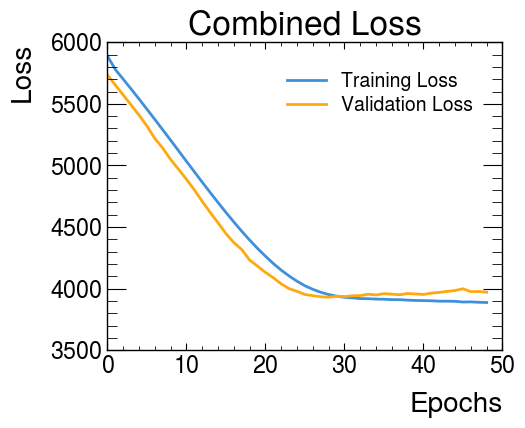

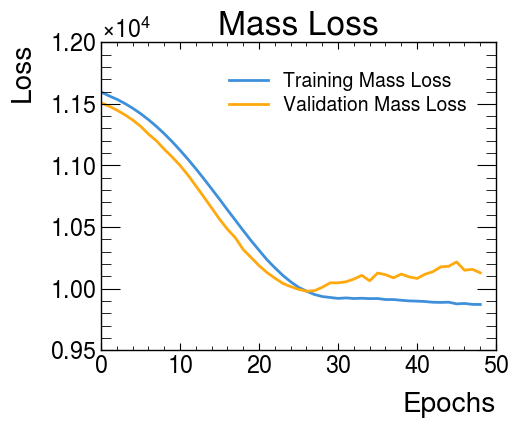

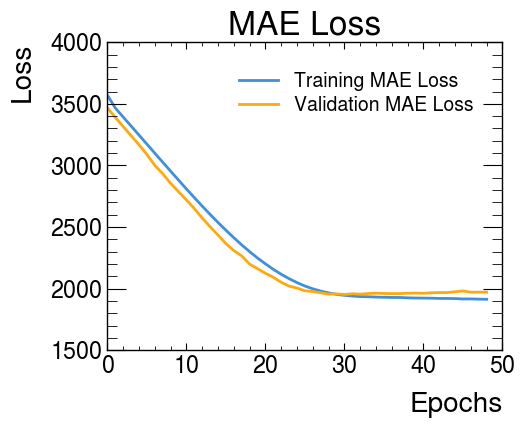

In [36]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mass_loss = history.history["mass_loss"]
val_mass_loss = history.history["val_mass_loss"]
mae_loss = history.history["mae_loss"]
val_mae_loss = history.history["val_mae_loss"]

# 1) Plot combined training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss")
plt.legend()
plt.grid(False)
plt.show()

# 2) Plot mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mass_loss, label="Training Mass Loss")
plt.plot(val_mass_loss, label="Validation Mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 3) Plot MAE training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mae_loss, label="Training MAE Loss")
plt.plot(val_mae_loss, label="Validation MAE Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MAE Loss")
plt.legend()
plt.grid(False)
plt.show()

In [37]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: 0.016, std: 27.267, min: -356.988, max: 385.778


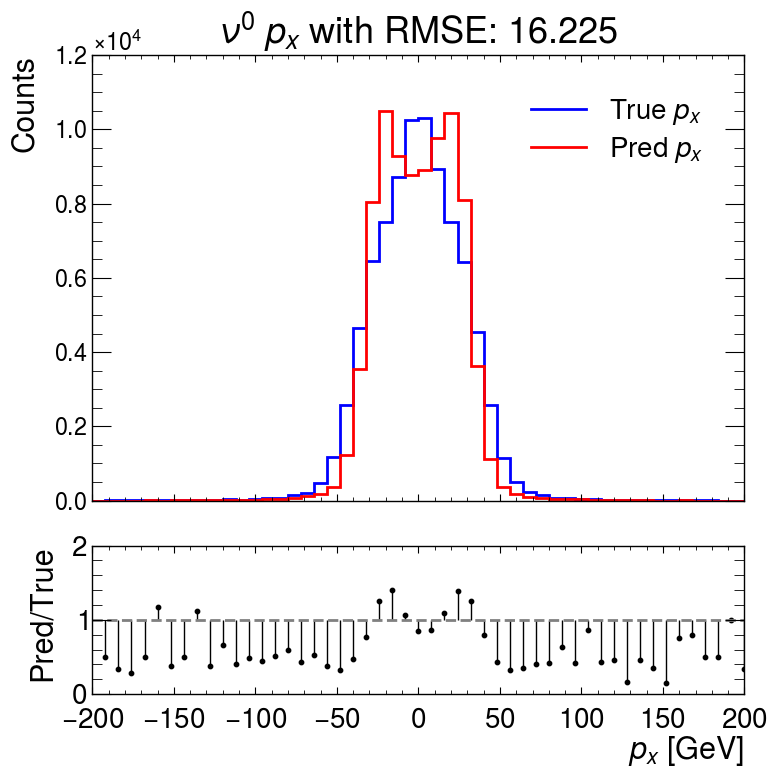

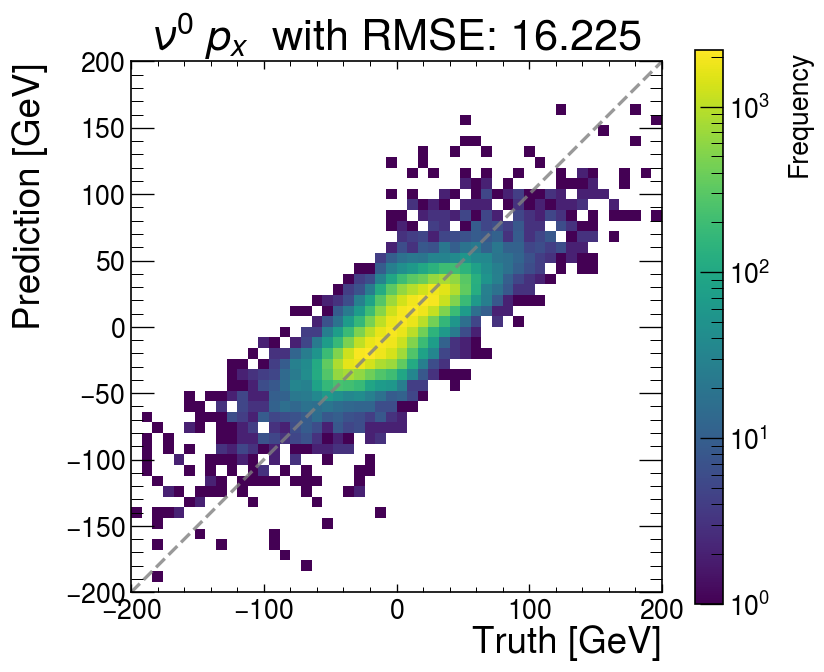

In [38]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}$",
    title=r"$\nu^{0}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"$\nu^{0}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50,
)

Truth mean: 0.040, std: 27.183, min: -512.008, max: 450.312


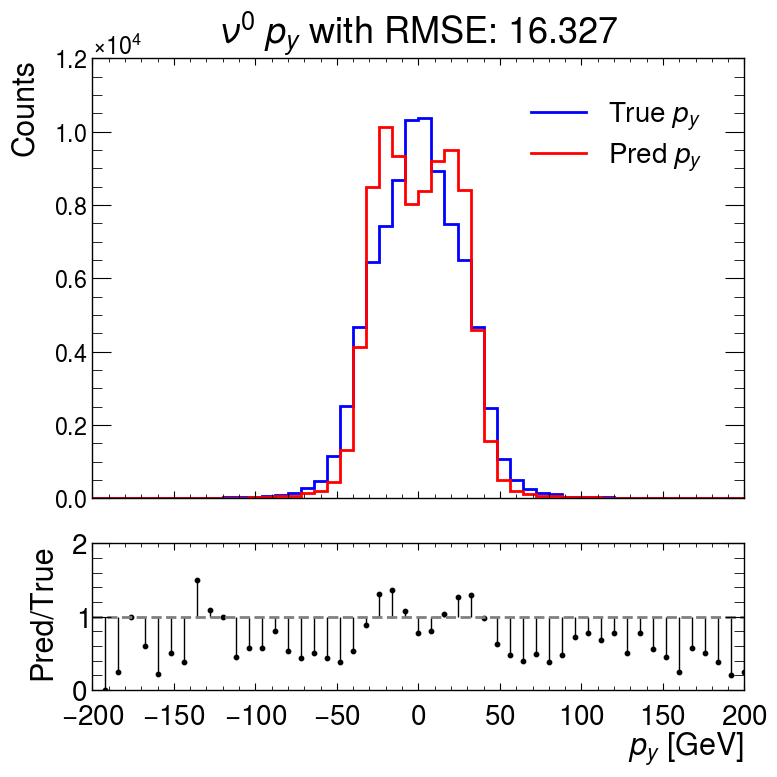

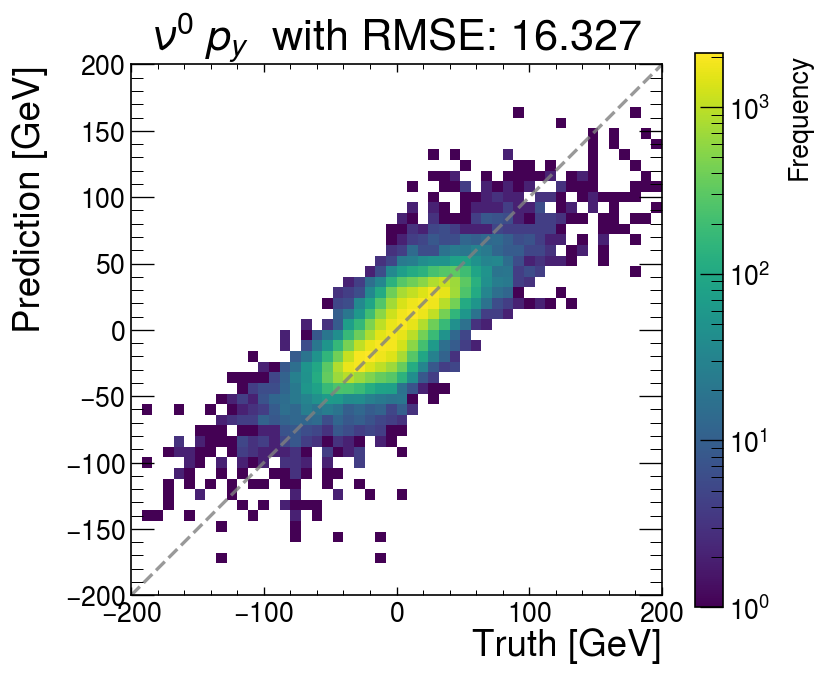

In [39]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}$",
    title=r"$\nu^{0}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$\nu^{0}$ $p_{y}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50 
)

Truth mean: -0.034, std: 100.251, min: -1264.236, max: 1282.273


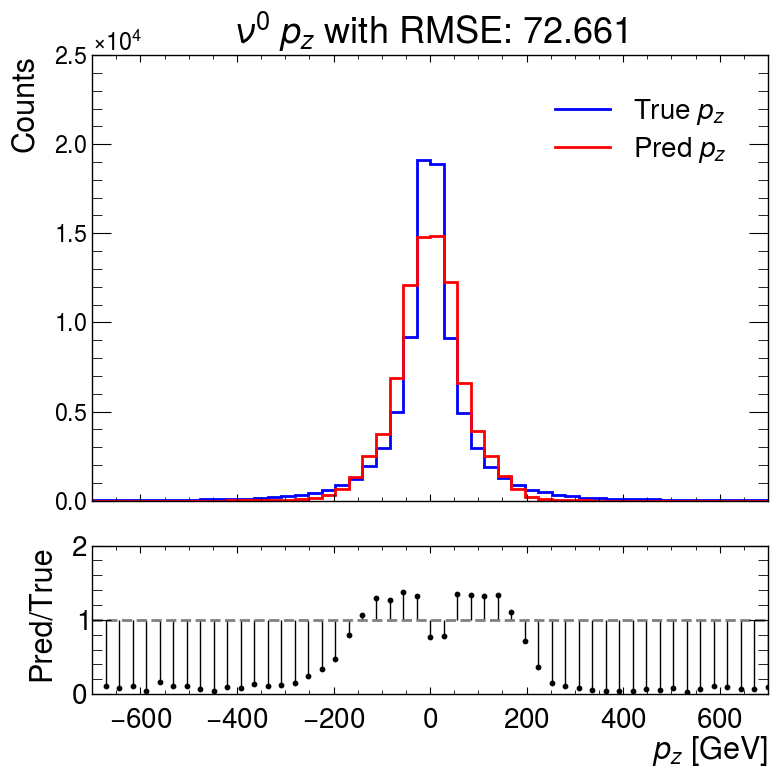

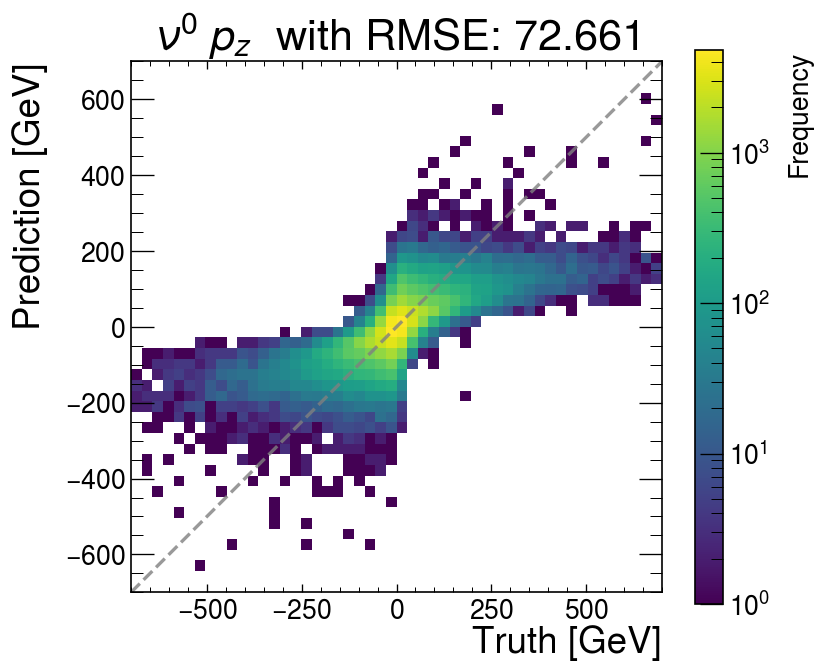

In [40]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}$",
    title=r"$\nu^{0}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"$\nu^{0}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 75.187, std: 76.678, min: 0.357, max: 1309.564


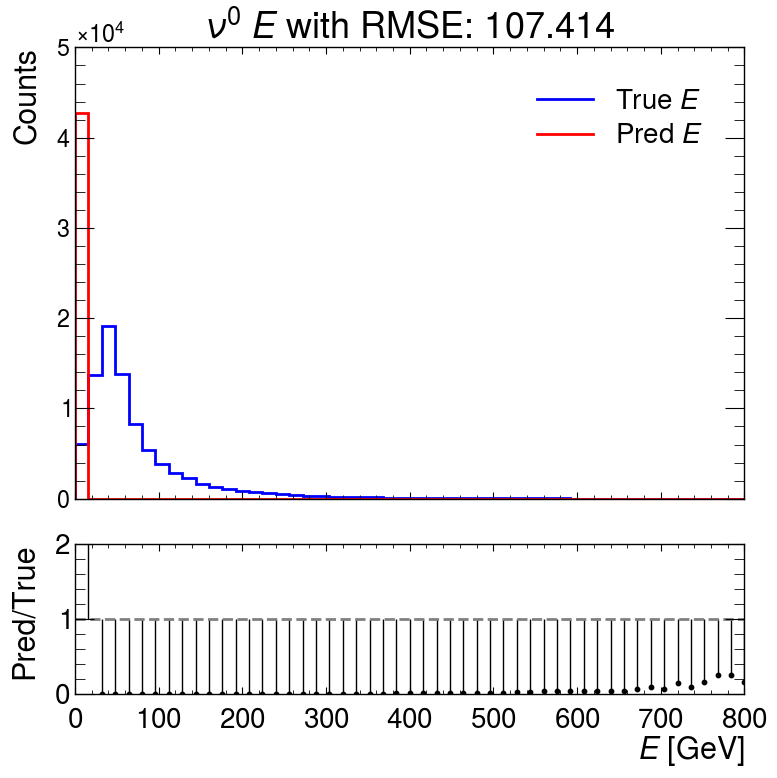

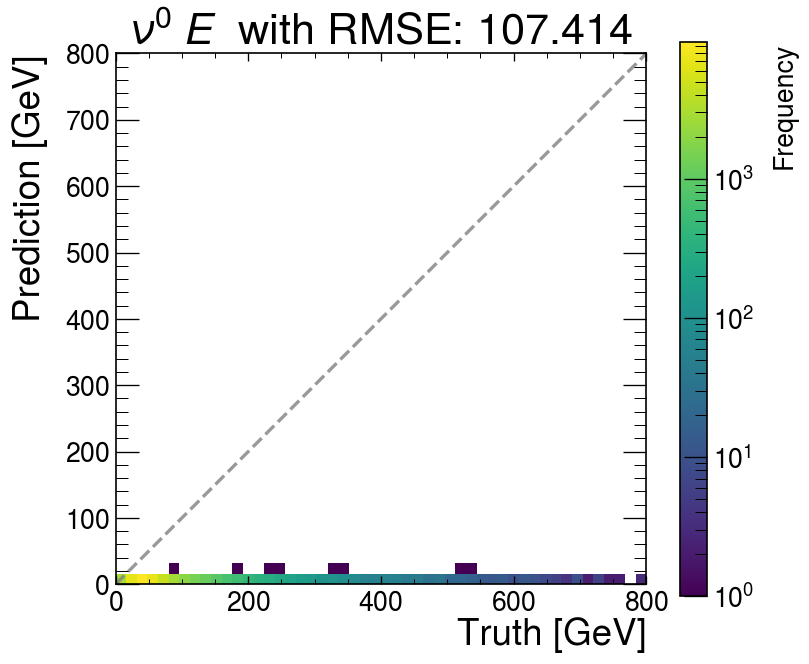

In [41]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title=r"$\nu^{0}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"$\nu^{0}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

In [42]:
stop!!!

SyntaxError: invalid syntax (1397269828.py, line 1)

In [ ]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$\nu^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like (TL) evts",
    fontsize=26,
    )
plt.legend(loc="upper right", prop={'size': 20})  # Adjust the size value as needed
plt.show()

In [ ]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]

plot.hist(
    data=[truth_m2, pred_m2],
    label=r"$m_{W}^{2}$",
    title="$m_{W}^{2}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    unit=r"[GEV$^{2}$]",
    xpad=24,
    # weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

plot.plot_2d_histogram(
    truth_m2,
    pred_m2,
    r"$m_{W}^{2}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    xpad=24,
    bins=50,
    # weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

In [26]:

# TODO: CGLMP

def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )
    
def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))
    
    # Unpack the results
    bij, xi_p, xi_n = zip(*results)
    
    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [27]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000,:]
xi_p = result_generator(particles)[1][0:80_000,:]
xi_n = result_generator(particles)[2][0:80_000,:]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000,:]
truth_xi_p = result_generator(particles)[1][0:80_000,:]
truth_xi_n = result_generator(particles)[2][0:80_000,:]

In [ ]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,0]):.3f}, std: {np.std(truth_bij[:,0]):.3f}, min: {np.min(truth_bij[:,0]):.3f}, max: {np.max(truth_bij[:,0]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,0]):.3f}, std: {np.std(bij[:,0]):.3f}, min: {np.min(bij[:,0]):.3f}, max: {np.max(bij[:,0]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,0], bij[:,0]],
    label=r"$B_{xy}$",
    title=rf"$B_{{xy}}={np.mean(bij[:,0]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,0]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,0],
    bij[:,0],
    r"$B_{xy}$",
    range=set_range,
    weights=None,
    bins=50
)

In [ ]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,1]):.3f}, std: {np.std(truth_bij[:,1]):.3f}, min: {np.min(truth_bij[:,1]):.3f}, max: {np.max(truth_bij[:,1]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,1]):.3f}, std: {np.std(bij[:,1]):.3f}, min: {np.min(bij[:,1]):.3f}, max: {np.max(bij[:,1]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,1], bij[:,1]],
    label=r"$B_{yz}$",
    title=rf"$B_{{yz}}={np.mean(bij[:,1]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,1]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,1],
    bij[:,1],
    r"$B_{yz}$",
    range=set_range,
    weights=None,
    bins=50
)

In [ ]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,2]):.3f}, std: {np.std(truth_bij[:,2]):.3f}, min: {np.min(truth_bij[:,2]):.3f}, max: {np.max(truth_bij[:,2]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,2]):.3f}, std: {np.std(bij[:,2]):.3f}, min: {np.min(bij[:,2]):.3f}, max: {np.max(bij[:,2]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,2], bij[:,2]],
    label=r"$B_{zx}$",
    title=rf"$B_{{zx}}={np.mean(bij[:,2]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,2]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,2],
    bij[:,2],
    r"$B_{zx}$",
    range=set_range,
    weights=None,
    bins=50
)

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,0], xi_p[:,0]],
    label=r"$\xi^{(0)}_{n}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,0],
    xi_p[:,0],
    r"$\xi^{(0)}_{n}$",
    range=set_range,
    weights=None,
    bins=50
)

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,1], xi_p[:,1]],
    label=r"$\xi^{(0)}_{r}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,1],
    xi_p[:,1],
    r"$\xi^{(0)}_{r}$",
    range=set_range,
    weights=None,
    bins=50
)

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,2], xi_p[:,2]],
    label=r"$\xi^{(0)}_{k}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,2],
    xi_p[:,2],
    r"$\xi^{(0)}_{k}$",
    range=set_range,
    weights=None,
    bins=50
)

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_n[:,0], xi_n[:,0]],
	label=r"$\xi^{(1)}_{n}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,0],
	xi_n[:,0],
	r"$\xi^{(1)}_{n}$",
	range=set_range,
	weights=None,
	bins=50
)

In [ ]:
set_range = [-1, 1]

plot.hist(	
	data=[truth_xi_n[:,1], xi_n[:,1]],
	label=r"$\xi^{(1)}_{r}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,1],
	xi_n[:,1],
	r"$\xi^{(1)}_{r}$",
	range=set_range,
	weights=None,
	bins=50
)

In [ ]:
set_range = [-1, 1]

plot.hist(
	data=[truth_xi_n[:,2], xi_n[:,2]],
	label=r"$\xi^{(1)}_{k}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,2],
	xi_n[:,2],
	r"$\xi^{(1)}_{k}$",
	range=set_range,
	weights=None,
	bins=50
)